## Overview

In this notebook, we will load all maps from the other tutorials (except task-fMRI) and consider the relationships between them. For this, we will apply spatial correlation with the anterior-posterior and proximal-distal axes of the hippocampus, as well as all permutations of rank-ordered subfield labels. Finally, we apply data-driven dimensionality reduction using Gradient decomposition

In [1]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import nibabel as nib
import scipy
from scipy.stats import spearmanr
from itertools import product
import hippomaps as hm
import copy
import glob
from brainspace.gradient import GradientMaps

In [2]:
# A list of all the data to be examined, grouped roughly into methodologies
files = [
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-BigBrain/histology-Merker_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-AxerPLI/histology-PLI-transmittance_average-1_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Bieloschowsky_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Blockface_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Parvalbumin_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Thionin_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Calbindin_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-AHEAD/histology-Calretinin_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
    
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-AHEAD/MRI-9p4T-qR1_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-AHEAD/MRI-9p4T-qR2star_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-AHEAD/MRI-9p4T-ProtonDensity_average-4_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-qT1_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-FA_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-ADC_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-T2star_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-MTR_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',

 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-rsfMRI-IntTS_average-99_hemi-L_den-2mm_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-rsfMRI-ReHo_average-99_hemi-L_den-2mm_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-rsfMRI-avgFCneocort_average-80_hemi-L_den-2mm_label-hipp.shape.gii',

 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BandPower-delta_average-81_hemi-mix_den-2mm_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BandPower-theta_average-81_hemi-mix_den-2mm_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BandPower-alpha_average-81_hemi-mix_den-2mm_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BandPower-beta_average-81_hemi-mix_den-2mm_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-MICs+Frauscher/iEEG-BandPower-gamma_average-81_hemi-mix_den-2mm_label-hipp.shape.gii',

 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-Mixed/histology-curvature_average-7_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-curvature_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-Mixed/histology-gyrification_average-7_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-gyrification_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-Mixed/histology-thickness_average-7_hemi-mix_den-unfoldiso_label-hipp.shape.gii',
 '../../publication-hippomaps/maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-thickness_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii',
 ]

In [3]:
# organize into sensible blocks of the same modality
blocks_len = [8,8,3,5,6]
blocks = np.concatenate(([0],np.cumsum(blocks_len)))
# apply a consistent color scheme per methodology
colors = np.hstack((np.ones((blocks_len[0])),np.ones((blocks_len[1]))+1,np.ones((blocks_len[2]))+2,np.ones((blocks_len[3]))+3,np.ones((blocks_len[4]))+4))
# sub label each map within each modality
feature_n = np.array([])
for f in blocks_len:
    feature_n = np.concatenate((feature_n,np.arange(1,f+1)))

## 1) Load and resample

Because these maps have verying resolutions, or surface densities, we will resample them all to 0.5mm vertex spacing

In [5]:
# load all data and resample to a common surface density
features = []
cdata = np.ones((7262,len(files)))
for f in range(len(files)):
    features.append(files[f].split('/')[-1].split('_')[0])
    den = files[f].split('/')[-1].split('_')[3][4:]
    cdata[:,f],_,_ = hm.utils.density_interp(den,'0p5mm',nib.load(files[f]).darrays[0].data, label='hipp')

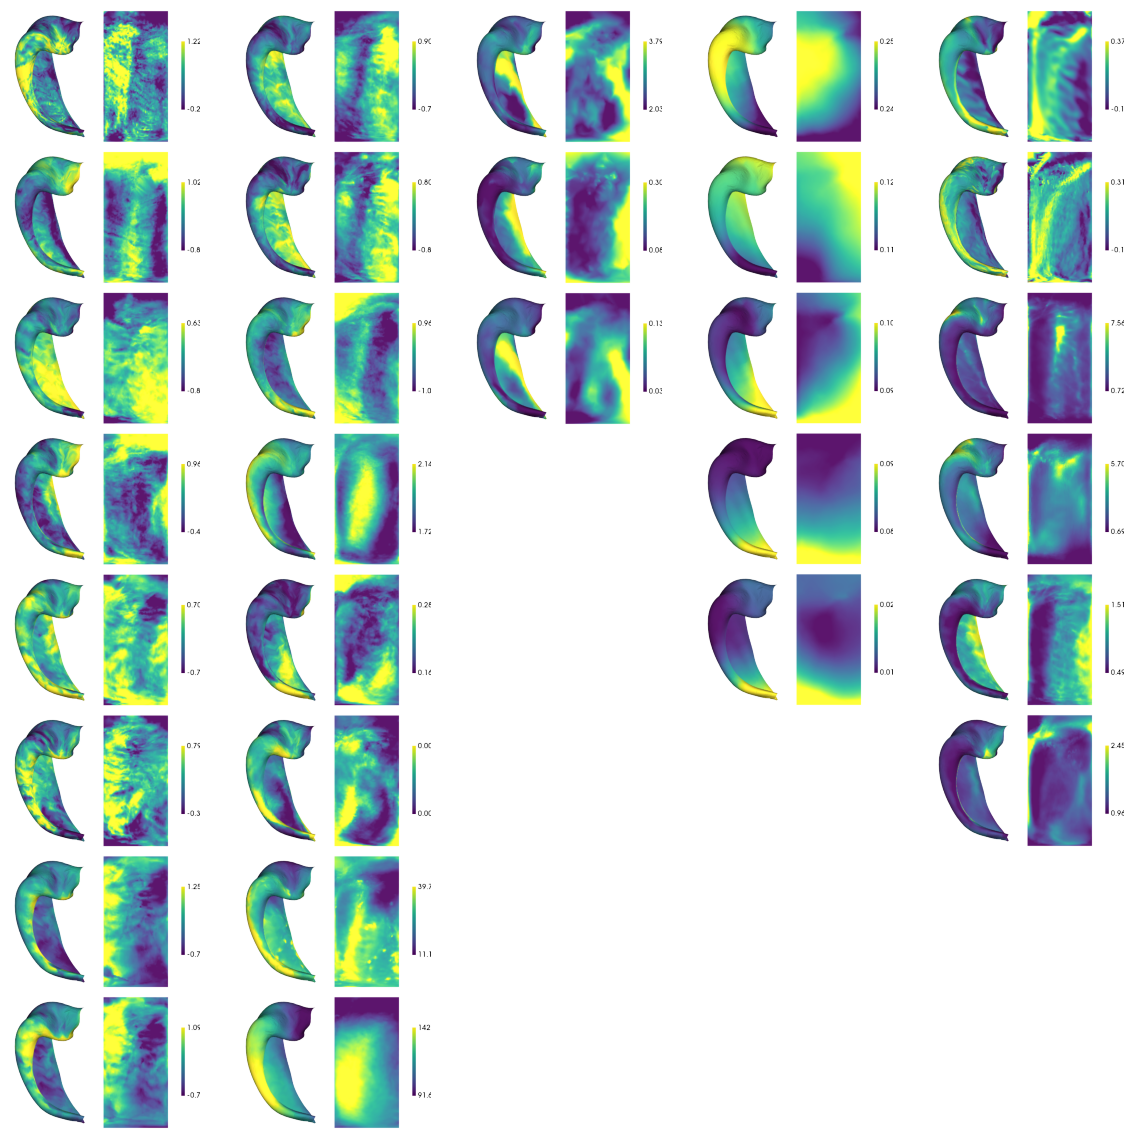

In [7]:
# plot all feature maps in the same plot
# the easiest way to do this is actually to save each set of maps as an image, and then tile all images together

fig, ax = plt.subplots(1,5, figsize=(20,50))
for b in range(5):
    hm.plotting.surfplot_canonical_foldunfold(cdata[:,blocks[b]:blocks[b+1]], color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', tighten_cwindow=True, embed_nb=True, screenshot=True, filename='tmp.png')
    f = plt.imread('tmp.png')
    ax[b].imshow(f)
    ax[b].set_axis_off()
    ax[b].set_anchor("NW")

!rm tmp.png

In [5]:
# check for significant correlation (spin test) (slow!)

feat_corr_p = np.ones((len(features),len(features)))
for i in range(len(features)):
    for j in range(i+1,len(features)):
        _,_,feat_corr_p[i,j],_ = hm.stats..spin_test(cdata[:,i],cdata[:,j], 10000, space='orig')

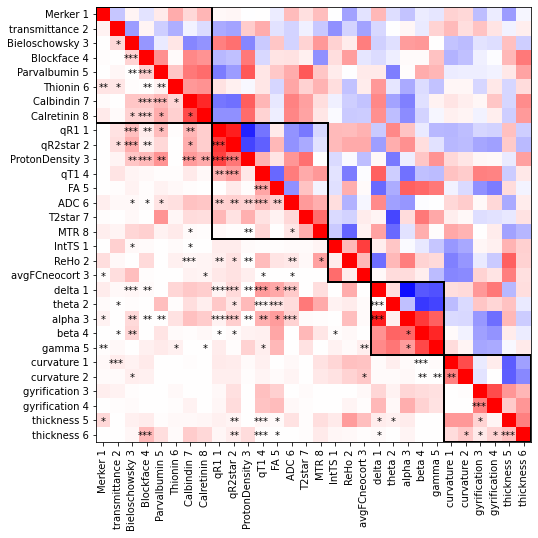

In [59]:
# plot correlation between features

feat_corr = np.corrcoef(cdata.T)

# bottom left will show Rsquared
iloc = np.tril_indices(len(feat_corr))
feat_corr[iloc] = feat_corr[iloc]**2

# plot and label
features_suffix = []
for f,feat in enumerate(features):
    features_suffix.append(feat.split('-')[-1] + ' ' + str(int(feature_n[f])))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(feat_corr, vmin=-1, vmax=1, cmap='bwr')
plt.yticks(ticks=range(len(features)),labels=features_suffix);
plt.xticks(ticks=range(len(features)),labels=features_suffix, rotation=90);

# box around same methodologies
for i in range(len(blocks)-1):
    w = blocks[i+1]-blocks[i]
    rect = Rectangle((blocks[i]-.5,blocks[i]-.5),w,w, linewidth=2, edgecolor='k', facecolor='none')
    ax.add_patch(rect)

# annotate significant correlations
for i in range(len(features)):
    for j in range(i+1,len(features)):
        if feat_corr_p[i,j] < 0.001:
            plt.annotate('***', (i-.6,j+.3));
        elif feat_corr_p[i,j] < 0.01:
            plt.annotate('**', (i-.3,j+.3));
        elif feat_corr_p[i,j] < 0.05:
            plt.annotate('*', (i-.15,j+.3));

## 2) Check for correlations with AP, PD, or subfield organizations

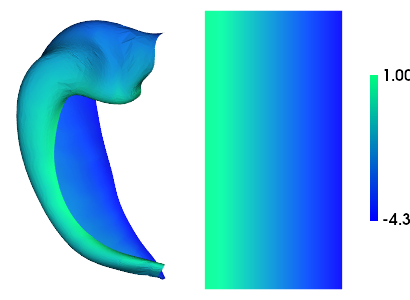

In [18]:
# here we can generate the PD axis. We generate a gradient in a flat 'unfoldiso' density, and then resample it to the present 0p3m surface density
PD,_,_ = hm.utils.density_interp('unfoldiso','0p5mm',repmat(np.linspace(0,1,126),254,1).T.flatten(), label='hipp')
hm.plotting.surfplot_canonical_foldunfold(PD, color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', cmap='winter', tighten_cwindow=False, embed_nb=True)

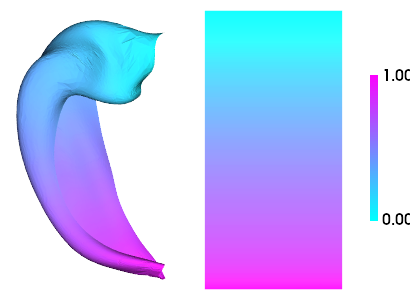

In [19]:
# same as above, for the AP axis
AP,_,_ = hm.utils.density_interp('unfoldiso','0p5mm',repmat(np.linspace(0,1,254),126,1).flatten(), label='hipp')
hm.plotting.surfplot_canonical_foldunfold(AP, color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', cmap='cool', tighten_cwindow=False, embed_nb=True)

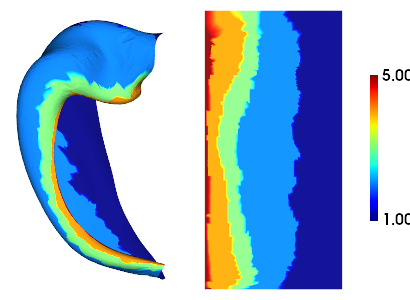

In [20]:
# load subfields from resources
subfields = nib.load(f'{hm.__path__[0]}/../resources/parc-multihist7/sub-0_hemi-0_space-0_den-0p5mm_label-hipp_atlas-multihist7_subfields.label.gii').darrays[0].data
hm.plotting.surfplot_canonical_foldunfold(subfields, color_bar=('right'), hemis=['L'], labels=['hipp'], cmap='jet', unfoldAPrescale=True, share='row', tighten_cwindow=False, embed_nb=True)

In [22]:
# generate permutations of subfields labels, since intensities may not change step-wise as they do in our labelling scheme

perms = list(product([1,2,3,4,5],repeat=5))
subfields_permuted = np.ones((len(subfields),len(perms)))*np.nan
for p in range(len(perms)):
    newsf = np.ones((len(subfields)))*np.nan
    for s in range(5):
        newsf[subfields==s+1] = perms[p][s]
    subfields_permuted[:,p] = newsf

Now we can determine whether features are most correlated with the AP axis, PD axis, or permuted subfields

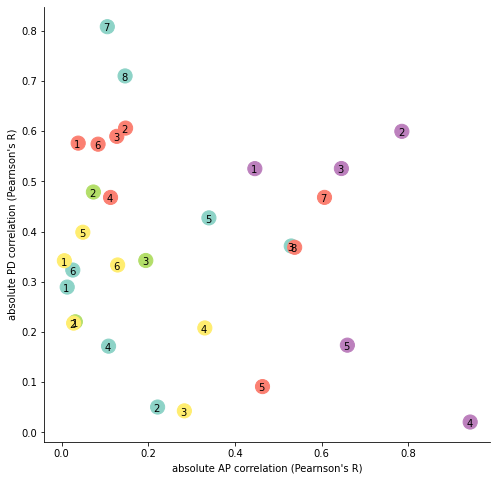

In [23]:
axiscorrAPPD = np.abs(np.corrcoef(np.concatenate((cdata,AP.reshape(7262,1),PD.reshape(7262,1)),axis=1).T)[-2:,:-2])

fig, ax = plt.subplots(figsize=(8,8))
ax.spines[['right', 'top']].set_visible(False)
ax.scatter(axiscorrAPPD[0],axiscorrAPPD[1],c=colors,cmap='Set3', s=200)
plt.xlabel("absolute AP correlation (Pearnson's R)")
plt.ylabel("absolute PD correlation (Pearnson's R)")

for f,feature in enumerate(features):
    ax.annotate(str(int(feature_n[f])), (axiscorrAPPD[0,f]-.009, axiscorrAPPD[1,f]-.009))

/export03/data/opt/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/export03/data/opt/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


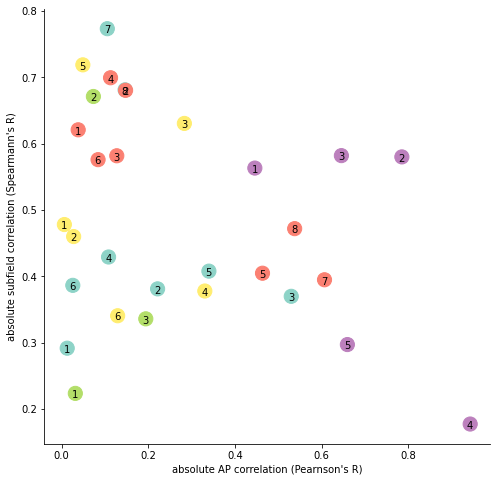

In [24]:
subfieldscorr = np.abs(spearmanr(np.concatenate((cdata,subfields_permuted),axis=1))[0][len(features):,:len(features)])
subfieldsmaxcorr = np.nanmax(subfieldscorr,axis=0)

fig, ax = plt.subplots(figsize=(8,8))
ax.spines[['right', 'top']].set_visible(False)
ax.scatter(axiscorrAPPD[0],subfieldsmaxcorr,c=colors,cmap='Set3',s=200)
plt.ylabel("absolute subfield correlation (Spearmann's R)")
plt.xlabel("absolute AP correlation (Pearnson's R)")

for f,feature in enumerate(features):
    ax.annotate(str(int(feature_n[f])), (axiscorrAPPD[0,f]-.008, subfieldsmaxcorr[f]-.007))

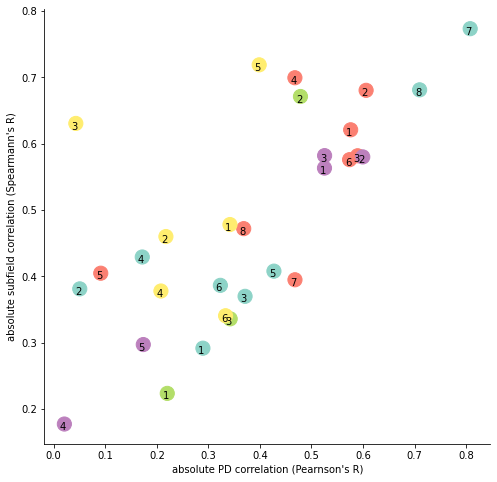

In [25]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(axiscorrAPPD[1],subfieldsmaxcorr,c=colors,cmap='Set3',s=200)
ax.spines[['right', 'top']].set_visible(False)
plt.ylabel("absolute subfield correlation (Spearmann's R)")
plt.xlabel("absolute PD correlation (Pearnson's R)")

for f,feature in enumerate(features):
    ax.annotate(str(int(feature_n[f])), (axiscorrAPPD[1,f]-.009, subfieldsmaxcorr[f]-.009))

In [26]:
# save these for adding and comparing with new features using the new function hm.stats.contextualize2D
np.savez('../resources/2Dcontextualize/initialHippoMaps', features=features, featureData = cdata, feature_n=feature_n, axiscorrAPPD=axiscorrAPPD, subfieldsmaxcorr=subfieldsmaxcorr, AP=AP, PD=PD, subfields_permuted=subfields_permuted, colors=colors)

## 3) Gradient decomposition

Just as in the other tutorials, we will combine features to generate primary gradients. Here, we use all maps, with Pearson's R for for affinity matrix kernel. Since each map is also an average of many subjects, we reduce sparsity from its default 0.9 to 0.1 in order to better leaverage even low values (since we still have high confidence in them)

In [27]:
# gradient decomposition
ngrads=5
mmgm = GradientMaps(n_components=ngrads, kernel='pearson', random_state=0)
mmgm.fit(scipy.stats.zscore(cdata), sparsity=0.1)

GradientMaps(kernel='pearson', n_components=5, random_state=0)

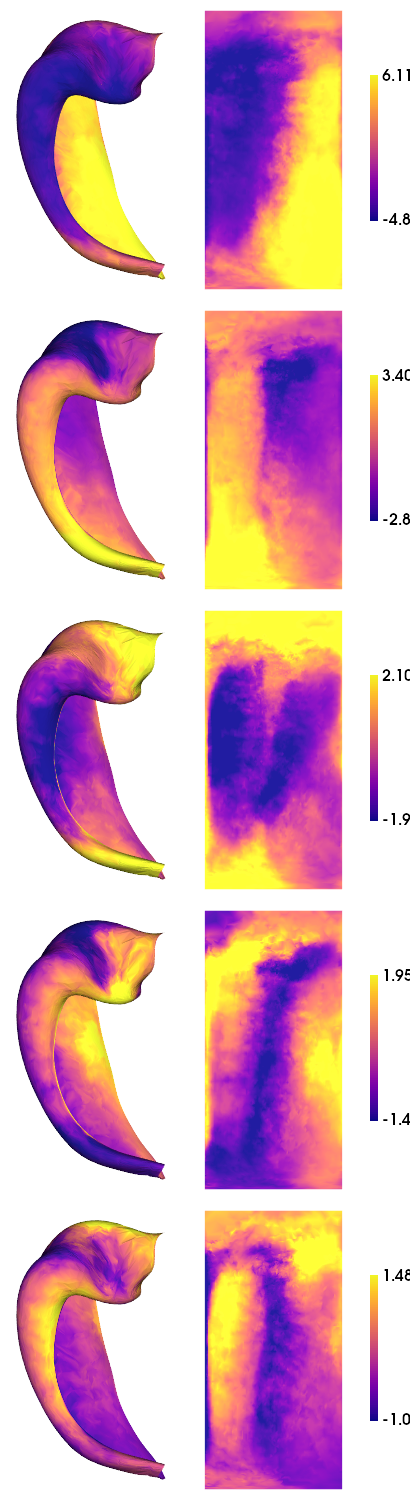

In [28]:
hm.plotting.surfplot_canonical_foldunfold(mmgm.gradients_, labels=['hipp'], hemis=['L'], unfoldAPrescale=True, cmap='plasma', color_bar='right', share='row', tighten_cwindow=True, embed_nb=True)

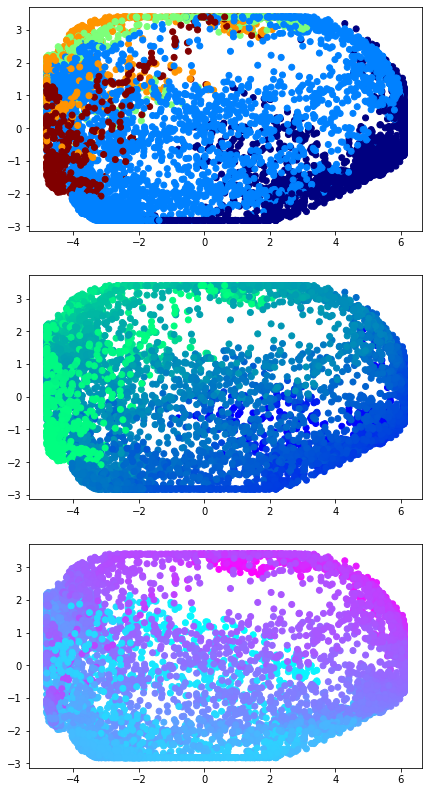

In [29]:
# instead of plotting gradients onto space, we can also plot space into gradients! In this case, space will be the subfield identities, AP coordinates, or PD coordinates

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 14))
ax[0].scatter(mmgm.gradients_[:,0], mmgm.gradients_[:,1], c=subfields, cmap='jet')
ax[0].set_aspect('equal', 'box')
ax[1].scatter(mmgm.gradients_[:,0], mmgm.gradients_[:,1], c=PD, cmap='winter')
ax[1].set_aspect('equal', 'box')
ax[2].scatter(mmgm.gradients_[:,0], mmgm.gradients_[:,1], c=AP, cmap='cool')
ax[2].set_aspect('equal', 'box')

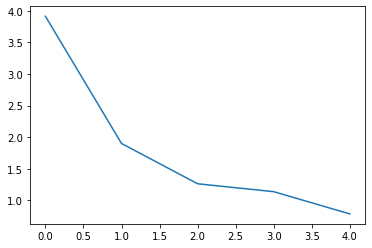

In [123]:
# we can also see the lambda value (or eigenvalue) for each gradient
plt.plot(mmgm.lambdas_)

In [80]:
# convert into a percentage of explained variance
mmgm.lambdas_/np.sum(mmgm.lambdas_)

array([0.43467193, 0.21114414, 0.14034947, 0.12646083, 0.08737363])